# Twitter Data Analysis

## Setup

In [ ]:
# # google colab setup 

# from google.colab import drive
# drive.mount("/content/drive")

# DRIVE_PATH = "/content/drive/MyDrive/twitter-inflation-perception/"

# import os
# os.chdir(DRIVE_PATH+"notebooks/")

# # libraries to install in google colab

# !pip install transformers==4.25.1
# !pip install sentencepiece

In [139]:
import sys 
sys.path.append("../")

In [140]:
from itertools import chain 
from collections import Counter 

In [655]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud

import pickle as pkl
import json 

from tqdm import tqdm 

# used for linear regression 
import statsmodels.api as sm

In [142]:
# libraries for topic modeling

from gensim.models import LdaModel
from gensim import corpora

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [192]:
# text preprocessing methods

from lib.preprocessing.tweets import clean_tweet 
from lib.preprocessing.text import (
    tokenize, 
    remove_punctuation, 
    remove_stopwords, 
    stem
)

# sentiment analysis methods 

from lib.sentiment.preprocessing import (
    load_tokenizer, 
    preprocess, 
)
from lib.sentiment.model import load_model 
from lib.sentiment.validation import predict
from lib.sentiment.utils import tensor_to_numpy

In [182]:
import torch 
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    RandomSampler, 
)

## Dataset

### Load tweets & classifier

Here we import the manually annotated dataset, the embeddings as well as the best classifier trained in the [tw-classification](tw-classification.ipynb) notebook. Since only 1,000 tweets has been manually annotated, the goal is to use the classifier in order to identify price-related tweets in the remanining tweets.  

In [144]:
data_path = "../backup/data/df_annotated.csv"
df = pd.read_csv(data_path)

# convert date to datetime object 
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [145]:
df.head()

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,label
0,2020-01-01,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,cheap,NaN,NaN
1,2020-01-01,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,cheap,Pour ceux qui veulent allier l'utile à l'agréa...,NaN
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,not_about_prices
3,2020-01-02,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,3.0,1.0,NaN,cheap,NaN,NaN
4,2020-01-06,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,284.0,69.0,36.0,cheap,Un iPhone pas cher ? C’est maintenant possible...,NaN


In [146]:
clf_path = "../backup/models/xgb_model.pkl"

with open(clf_path, "rb") as f: 
    clf = pkl.load(f)

embeddings_path = "../backup/data/embeddings.npy"
embeddings = np.load(embeddings_path)

print(f"Dimension of each embedding: {embeddings.shape[1]}")

Dimension of each embedding: 384


In [147]:
# check whether the embeddings and dataset are equal length
assert embeddings.shape[0] == df.shape[0]

### Identify prices-related tweets with ML

The annotated dataset contains the `label` column which consists in 6 categories. One can notice very few observations for categories that are not "not_about_prices" or "inflation". It is decided to create the `on_topic` variable which is 1 if the tweet is related to prices (inflation, deflation, etc.), 0 otherwise.

Note we only apply the transformation on tweets that have been manually annotated.

In [148]:
df["label"].value_counts()

not_about_prices    684
inflation           302
desinflation         14
other                11
deflation             5
stability             2
Name: label, dtype: int64

In [149]:
def add_on_topic_variable(label: str) -> int: 
    """Description. Indicate whether tweet is about prices or not."""
    if label == "not_about_prices": 
        return 0 
    else: 
        return 1

# get annotated row indices
annotated_idxs = df.loc[df.label.notna(), :].index.tolist()

df.loc[
    df.index.isin(annotated_idxs),
    "on_topic"
] = df.loc[
    df.index.isin(annotated_idxs), 
    "label"
].apply(add_on_topic_variable)

In [150]:
df["on_topic"].value_counts()

0.0    684
1.0    334
Name: on_topic, dtype: int64

Before predicting using the `XGBClassifier` model, it is important to distinguish already-annoated tweets from those to label. 

In [151]:
idxs_to_label = df.loc[df.label.isna(), :].index.to_list()

print(f"{len(idxs_to_label)} tweets to label")

91943 tweets to label


In [152]:
X = embeddings[idxs_to_label, :]
predicted_labels = clf.predict(X)

We finally add the predicted labels to the partially annotated dataset. 

In [153]:
df.loc[df.index.isin(idxs_to_label), "on_topic"] = predicted_labels

It seems interesting to check the consistency of the predictions outputed by the `XGBClassifier` by selecting random tweets and verify whether they are about prices.

In [154]:
ix = np.random.choice(a=idxs_to_label)

tweet = df["text"][ix]
on_topic = bool(df["on_topic"][ix])
print(tweet)
print(f"{on_topic=}")

6 ans de plus pour Josh Allen avec les Bills
Buffalo Bills
@BuffaloBills
·
6 Aug 2021
We’ve agreed to terms with QB Josh Allen on a six-year extension through 2028 #BillsMafia 

Details: http://bufbills.co/3lEIJy0
1
8
on_topic=False


### Extract prices-related tweets

The resulting dataset is made up of about 25% of tweets related to prices matter.

In [155]:
df["on_topic"].value_counts() / df.shape[0]

0.0    0.733103
1.0    0.266897
Name: on_topic, dtype: float64

We thus select the observations for which the `on_topic` variable is equal to 1 and duplicates are also removed.

In [156]:
df_prices = df.loc[df.on_topic==1, :]
print(f"{len(df_prices)} rows after filtering prices-related tweets")

df_prices = df_prices.drop_duplicates(subset=["text"])
print(f"{len(df_prices)} rows after removing duplicates")

24811 rows after filtering prices-related tweets
24312 rows after removing duplicates


In [157]:
tweets = df_prices["text"].tolist()
n_tweets = len(tweets)

print(f"{n_tweets} unique tweets in the dataset.")

24312 unique tweets in the dataset.


## Text preprocessing

1. Remove tweet attributes (mentions, links, etc.)

In [158]:
tweets_cleaned = [clean_tweet(tweet) for tweet in tweets]

In [159]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Before cleaning:\n{tweets[ix]}")
print(f"\n\nAfter cleaning:\n{tweets_cleaned[ix]}")

Before cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC


2. Tokenization

In [160]:
tweets_tokenized = [tokenize(tweet) for tweet in tweets_cleaned]

In [161]:
print(f"Before cleaning & tokenization:\n{tweets[ix]}")
print(f"\n\nAfter cleaning & tokenization:\n{tweets_tokenized[ix]}")

Before cleaning & tokenization:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After cleaning & tokenization:
['que', 'dieu', 'vienne', 'en', 'aide', 'à', 'toutes', 'ces', 'personnes', 'payées', 'en', 'francs', 'et', 'qui', 'malgré', 'l', '’', 'inflation', 'du', 'moment', ',', 'ne', 'sont', 'pas', 'augmentées', '.', '1', '$=', '1900fc', '?', 'c', '’', 'est', 'de', 'la', 'folie', '...', '#', 'rdc']


3. Remove punctuation and stopwords

In [162]:
tweets_no_punc = [remove_punctuation(tokens) for tokens in tweets_tokenized]

In [163]:
tweets_no_stopwords = [remove_stopwords(tokens) for tokens in tweets_no_punc]

In [164]:
print(f"Before full cleaning:\n{tweets[ix]}")
print(f"\n\nAfter full cleaning:\n{tweets_no_stopwords[ix]}")

Before full cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After full cleaning:
['dieu', 'vienne', 'aide', 'personnes', 'payées', 'francs', 'inflation', 'moment', 'pas', 'augmentées', '1', '1900fc', 'folie', 'rdc']


4. Update dataset 

- Add preprocessed tweets
- Add number of tokens per tweet

In [165]:
df_prices.loc[:, "tokens"] = np.array(tweets_no_stopwords, dtype=object) 
df_prices.loc[:, "n_tokens"] = df_prices.loc[:, "tokens"].apply(len)

## Data visualisation

### Tweet statistics

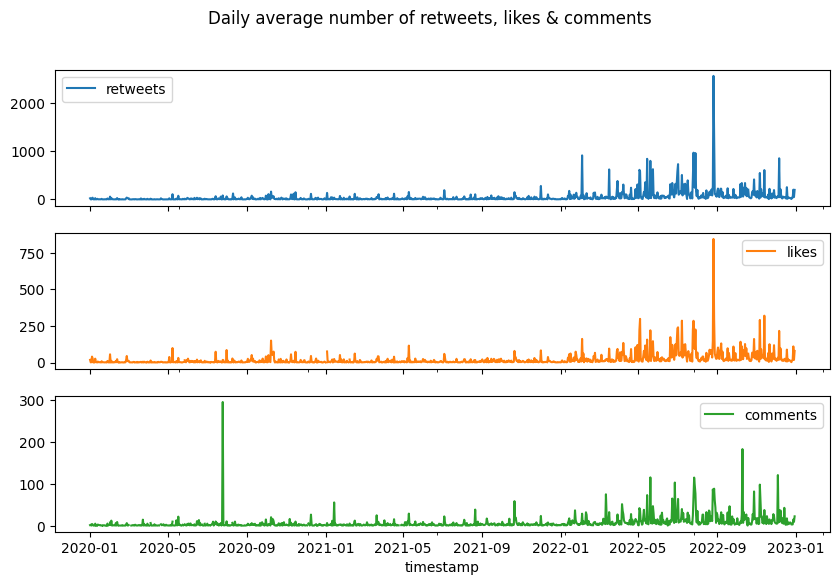

In [166]:
by = [df_prices.timestamp.dt.date]
num_cols = ["retweets", "likes", "comments"]

df_prices.\
    groupby(by)[num_cols].\
    mean().\
    plot(subplots=True, figsize=(10, 6), title="Daily average number of retweets, likes & comments"); 

### Text analysis

#### Frequencies of tokens

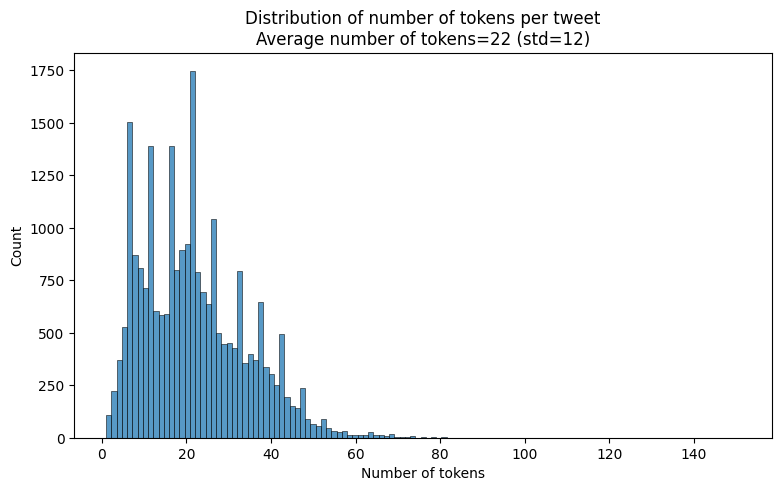

In [167]:
n_tokens_avg = np.mean(df_prices.n_tokens)
n_tokens_std = np.std(df_prices.n_tokens)

fig, ax = plt.subplots(figsize=(9, 5))

sns.histplot(data=df_prices, x="n_tokens", ax=ax)
ax.set_xlabel("Number of tokens")
ax.set_title(f"Distribution of number of tokens per tweet\nAverage number of tokens={round(n_tokens_avg)} (std={round(n_tokens_std)})");  

In [168]:
tokens = list(chain(*df_prices.tokens.values))
n_tokens = len(tokens)

In [169]:
token_counts = Counter(tokens)
top_n = 20

{
    k: round(100 * v / n_tokens, 2) 
    for k, v in dict(token_counts.most_common(top_n)).items()
}

{'inflation': 6.64,
 'prix': 1.1,
 'pas': 1.06,
 'taux': 0.82,
 'hausse': 0.72,
 '1': 0.62,
 '2': 0.61,
 '5': 0.47,
 'france': 0.42,
 '0': 0.41,
 '3': 0.38,
 '4': 0.35,
 'contre': 0.34,
 'économie': 0.33,
 '2021': 0.32,
 'banque': 0.32,
 'face': 0.32,
 'pouvoir': 0.32,
 'mois': 0.31,
 '2022': 0.3}

In [170]:
text = " ".join(tokens)
wordcloud = WordCloud(background_color="white", max_words = 50).generate(text)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Py

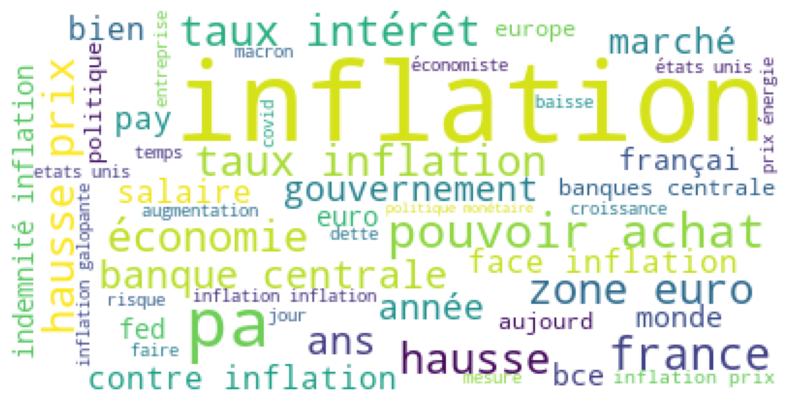

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(wordcloud)
ax.set_axis_off(); 

#### Topic detection

We use Latent Dirichlet Allocation implemented in the `gensim` library to identify topics in the collection of prices-related tweets (documents). LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

In [172]:
text_data = df_prices.tokens.to_list()

In [173]:
dictionary = corpora.Dictionary(text_data)

In [174]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [175]:
n_topics = 4
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=n_topics)

In [176]:
ldamodel.print_topics()

[(0,
  '0.058*"inflation" + 0.035*"taux" + 0.023*"prix" + 0.023*"banque" + 0.020*"hausse" + 0.017*"intérêt" + 0.014*"centrale" + 0.012*"2" + 0.011*"5" + 0.011*"1"'),
 (1,
  '0.041*"inflation" + 0.011*"fed" + 0.009*"guerre" + 0.008*"ukraine" + 0.008*"the" + 0.007*"“" + 0.006*"”" + 0.006*"to" + 0.005*"in" + 0.005*"of"'),
 (2,
  '0.066*"inflation" + 0.013*"pas" + 0.012*"prix" + 0.008*"face" + 0.006*"hausse" + 0.006*"contre" + 0.006*"faire" + 0.006*"france" + 0.006*"économie" + 0.005*"crise"'),
 (3,
  '0.044*"inflation" + 0.015*"pouvoir" + 0.015*"achat" + 0.015*"pas" + 0.014*"salaires" + 0.010*"€" + 0.010*"français" + 0.009*"gouvernement" + 0.008*"macron" + 0.008*"euros"')]

Let’s visualize the topics for interpretability using the `pyLDAvis` library which is designed to give: 
- a better understanding and interpretation of individual topics (most frequent and/or relevant terms per topic)
- a better understanding of the relationships between them (intertopic distance plot)

Note: you can download the `.html` file [here](./figs/lda_4_topics.html) to have better display.

In [177]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [179]:
pyLDAvis.save_html(lda_display, "../figs/lda_"+ str(n_topics)+"_topics.html")

## Sentiment analysis

This section aims at measuring the polarity of the selected tweets, that is to say assessing whether they are positive or negative. To that end, the transformer-based model trained in [tw-sentiment-camembert](tw-sentiment-camembert.ipynb) is used. This model having more than 110 milion parameters, we use the computational resources of Google Colaboratory for both training and prediction. 

### Load model 

In [183]:
model_path = "../backup/models/twitter-camembert.pt"
model = load_model(model_path)

Loading trained model...


In [184]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

model = model.to(device)

device=device(type='cpu')


### Preprocessing

In [187]:
tokenizer = load_tokenizer()

input_ids, attention_mask = preprocess(tweets, tokenizer)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [190]:
batch_size = 32
dataset = TensorDataset(
    input_ids,
    attention_mask)

dataloader = DataLoader(
    dataset,
    sampler = RandomSampler(dataset),
    batch_size = batch_size)

### Run model 

In [378]:
results = []
backup_path = "../backup/models/predictions-sentiment.json"

loop = tqdm(dataloader) 
loop.set_description("Predicting unseen tweets...")

for batch in loop:             
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    
    predicted_labels, scores = predict(input_id, attention_mask, model, eval_mode=False)
    predicted_labels = tensor_to_numpy(predicted_labels)
    scores = tensor_to_numpy(scores)

    results.append({
        "predicted_labels": predicted_labels.tolist(), 
        "softmax_scores": scores.tolist()
    })

    with open(backup_path, "w") as f: 
        json.dump(results, f)

### Get predicted sentiments

Since predictions have been generated using the resources provided by Google Colab, we load the [file](../backup/models/predictions-sentiment.json) in which they are stored. 

In [380]:
backup_path = "../backup/models/predictions-sentiment.json"
 
with open(backup_path, "r") as f: 
    predictions_sentiment = json.load(f)

In [381]:
# flatten predictions and store in numpy array

sentiments = list(chain(
    *[item["predicted_labels"] for item in predictions_sentiment]
))

sentiments = np.array(sentiments)

In [382]:
# flatten softmax scores and store in numpy array

scores = list(chain(
    *[np.max(item["softmax_scores"], axis=1) for item in predictions_sentiment]
))

scores = np.array(scores)

## Building the Twitter inflation indicator

### Helper functions

In [606]:
from pandas.core.frame import DataFrame

def add_ma(df: DataFrame, var: str, n: int) -> DataFrame: 
    """Description. Add the n-day moving average to df for var."""

    new_var = f"{var}_ma_{n}"
    df_agg[new_var] = df_agg[var].rolling(n).mean()

    return df

def standardize_column(df: DataFrame, col: str) -> DataFrame: 
    """Description. Standardize column in pandas dataframe."""

    new_col = f"{col}_std"
    df[new_col] = (df[col] - df[col].mean()) / df[col].std()

    return df

def get_correlation_coef(df: DataFrame, var1: str, var2: str, method: str="pearson") -> float: 
    """Description. 
    Compute linear coefficient correlation between two columns in pandas dataframe."""

    return df.loc[:, [var1, var2]].corr(method=method).iloc[0, 1]

### Create aggregated data set

First, we calculate the daily number of tweets related to prices matter. We then standardize this variable in order to avoid scaling issues.

In [632]:
by = [df_prices.timestamp.dt.date]

# aggregate by timestamp
df_agg = df_prices.\
    groupby(by).\
    size()
    
df_agg = pd.DataFrame(data=df_agg, columns=["count"])

# standardize daily number of tweets
df_agg = standardize_column(df_agg, "count")

df_agg.index = pd.to_datetime(df_agg.index)

Once the aggregated dataset built, we compute the 7/15/30-day moving average for both the non-standardized and standardized daily number of prices-related tweets.

In [633]:
for var in ("count", "count_std"): 
    for n in (7, 15, 30): 
        df_agg = add_ma(df_agg, var, n)

In [634]:
df_agg.tail()

,count,count_std,count_ma_7,count_ma_15,count_ma_30,count_std_ma_7,count_std_ma_15,count_std_ma_30
timestamp,,,,,,,,
2022-12-26,21,-0.165127,24.000000,22.933333,24.133333,0.214596,0.079583,0.231473
2022-12-27,25,0.341170,23.857143,23.733333,24.266667,0.196514,0.180843,0.248349
2022-12-28,19,-0.418276,23.571429,23.200000,23.800000,0.160350,0.113336,0.189281
2022-12-29,22,-0.038553,22.857143,23.333333,23.733333,0.069939,0.130213,0.180843
2022-12-30,29,0.847468,22.571429,23.600000,24.033333,0.033775,0.163966,0.218815


Here we plot the moving averages for the daily number of prices-related tweets to have a first glimpse of the general trend. 

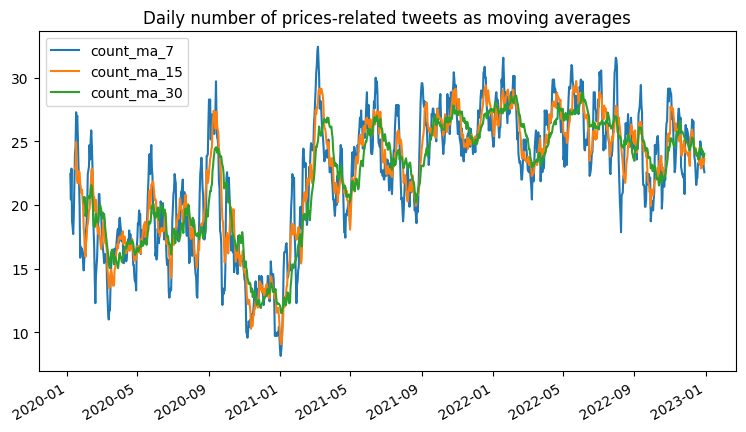

In [635]:
fig, ax = plt.subplots(figsize=(9, 5))

df_agg.loc[
    :, 
    df_agg.columns.str.contains("count_ma")
].plot(ax=ax) 
ax.set_title("Daily number of prices-related tweets as moving averages")
ax.set_xlabel(""); 

### Comparison with observed inflation rate from OCDE

With a view to get an insight on the accuracy of our methodology, we decide make a parallel with the actual inflation rate.

In [636]:
inflation = pd.read_csv("../backup/data/inflation-ocde.csv")

inflation["TIME"] = pd.to_datetime(inflation["TIME"])

inflation = inflation.loc[
    (inflation["LOCATION"] == "FRA") 
    & (inflation["TIME"] >= "2020-01-01"),
    ["TIME", "Value"] 
].reset_index(drop=True)

inflation.columns = inflation.columns.str.lower()
inflation = inflation.rename(columns={"time": "timestamp"})

inflation = standardize_column(inflation, "value")

inflation = inflation.set_index("timestamp")

Now the inflation data downloded from the OCDE website and standardized, it seems interesting to measure the linear correlation between the two variables. Before doing so, it is important to resample the Twitter indicator variable on a monthly basis.

**As of now, we define the Twitter count indicator as the monthly average number of tweets identified as related to prices.**

In [637]:
inflation["count"] = df_agg["count"].resample("MS").mean().values
inflation["count_std"] = df_agg["count_std"].resample("MS").mean().values

In [638]:
pearson_cor = get_correlation_coef(inflation, "value", "count")
spearman_cor = get_correlation_coef(inflation, "value", "count", method="spearman") 

print(f"Pearson correlation coefficient={round(pearson_cor, 3)}")
print(f"Spearman (rank) correlation coefficient={round(spearman_cor, 3)}")

Pearson correlation coefficient=0.652
Spearman (rank) correlation coefficient=0.72


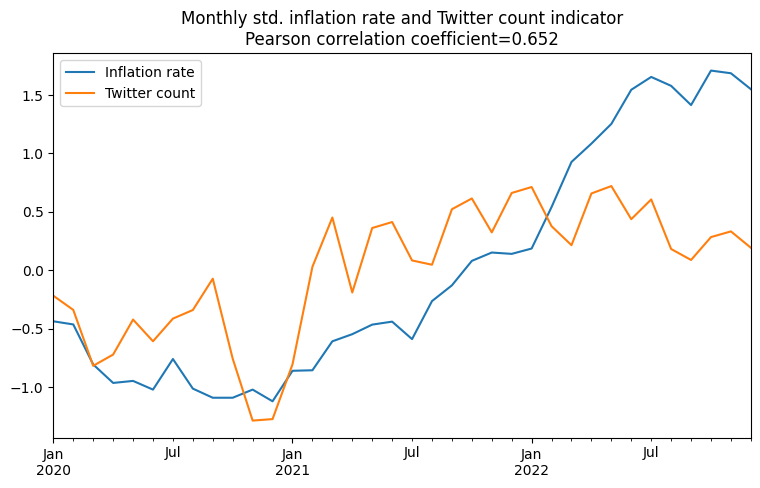

In [639]:
fig, ax = plt.subplots(figsize=(9, 5))

inflation.loc[:, ["value_std", "count_std"]].\
    rename(columns={
        "value_std": "Inflation rate", 
        "count_std": "Twitter count"
    }).\
    plot(ax=ax)

title = f"Monthly std. inflation rate and Twitter count indicator\nPearson correlation coefficient={round(pearson_cor, 3)}"
ax.set_title(title)
ax.set_xlabel(""); 

### Add results from sentiment analysis

Once the sentiment labels and predicted probabilities loaded, we add them to dataset containing tweets classified as prices-related. 

In [640]:
df_prices["sentiment_label"] = sentiments 
df_prices["sentiment_score"] = scores

Then, we compute the daily average sentiment and add the new features to the aggregated dataset.

In [641]:
tmp = df_prices.\
    groupby(by)["sentiment_label", "sentiment_score"].\
    mean()
tmp.index = pd.to_datetime(tmp.index)

df_agg = pd.concat([df_agg, tmp], axis=1)

C:\Users\pemma\AppData\Local\Temp\ipykernel_16836\3216464692.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_prices.\


As for the daily number of tweets, we apply standardization to both average sentiment labels and scores and compute the 30-day moving average.

In [642]:
df_agg = standardize_column(df_agg, "sentiment_label")
df_agg = add_ma(df_agg, "sentiment_label_std", 30)

df_agg = standardize_column(df_agg, "sentiment_score")
df_agg = add_ma(df_agg, "sentiment_score_std", 30)

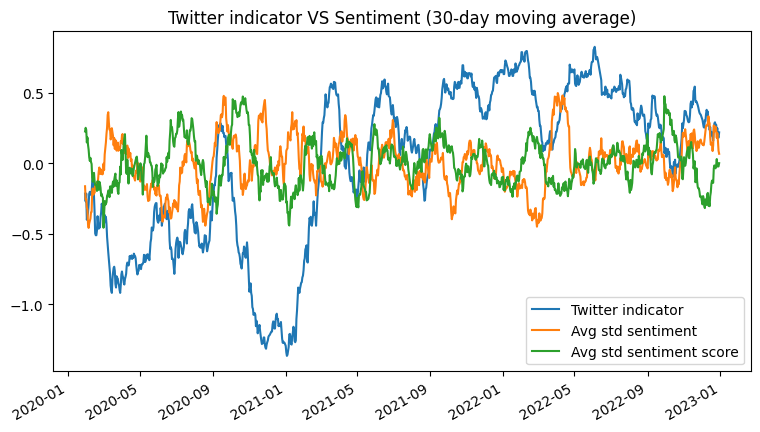

In [643]:
fig, ax = plt.subplots(figsize=(9, 5))

df_agg.loc[
    :, 
    ["count_std_ma_30", "sentiment_label_std_ma_30", "sentiment_score_std_ma_30"]
].rename(columns={
    "count_std_ma_30": "Twitter indicator", 
    "sentiment_label_std_ma_30": "Avg std sentiment", 
    "sentiment_score_std_ma_30": "Avg std sentiment score"
}).plot(ax=ax)

ax.set_xlabel("")
ax.set_title("Twitter indicator VS Sentiment (30-day moving average)"); 

We finally aggregate once again at a monthly level to have coherent features with the inflation data.

**We define the Twitter sentiment indicator as the monthly average sentiment label** (see the chunk below).

In [644]:
inflation["sentiment_label"] = df_agg["sentiment_label"].resample("MS").mean().values 
inflation["sentiment_score"] = df_agg["sentiment_score"].resample("MS").mean().values 

inflation["sentiment_label_std"] = df_agg["sentiment_label_std"].resample("MS").mean().values 
inflation["sentiment_score_std"] = df_agg["sentiment_score_std"].resample("MS").mean().values 

### Crossed evolution

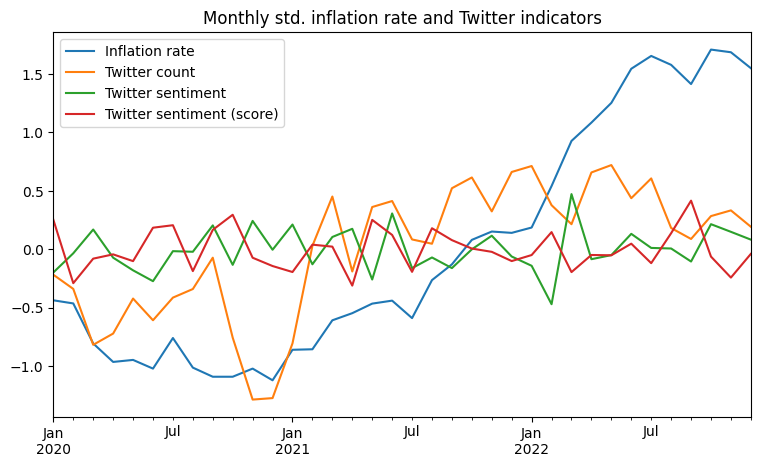

In [645]:
fig, ax = plt.subplots(figsize=(9, 5))

inflation.loc[:, ["value_std", "count_std", "sentiment_label_std", "sentiment_score_std"]].\
    rename(columns={
        "value_std": "Inflation rate", 
        "count_std": "Twitter count", 
        "sentiment_label_std": "Twitter sentiment", 
        "sentiment_score_std": "Twitter sentiment (score)"
    }).\
    plot(ax=ax)

title = f"Monthly std. inflation rate and Twitter indicators"
ax.set_title(title)
ax.set_xlabel(""); 

### Correlation matrix

In [646]:
cor_mat = inflation.\
    loc[:, ["value", "count", "sentiment_label", "sentiment_score"]].\
    rename(columns={
        "value": "Inflation rate", 
        "count": "Twitter count", 
        "sentiment_label": "Twitter sentiment", 
        "sentiment_score": "Twitter sentiment (score)"
    }).\
    corr(method="pearson")

cor_mat_sorted = cor_mat[["Inflation rate"]].\
    sort_values(by="Inflation rate", ascending=False)

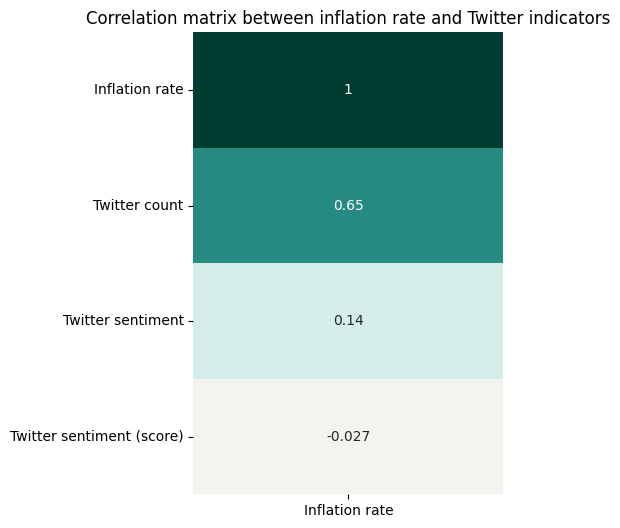

In [647]:
fig, ax = plt.subplots(figsize=(4, 6))

heatmap = sns.heatmap(
    cor_mat_sorted, 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap="BrBG", 
    cbar=False, 
    ax=ax)
heatmap.set_title("Correlation matrix between inflation rate and Twitter indicators");

### Linear regression 

The last step consists in assessing the predictive power of the Twitter count and Twitter sentiment indicators. For this purpose, we fit linear regressions where the endogeneous variable is the inflation rate and the exogeneous variables are the Twitter indicators. We try different settings in order to make the most of our indicators. 

In [673]:
endog = "value"
exog_vars = [
    "count", 
    "sentiment_label",
    "sentiment_score"
]

from itertools import chain, combinations

exog_grid = [
    list(combinations(exog_list, i))
    for i in range(1, len(exog_vars)+1)
]
exog_grid = list(chain(*exog_grid))

In [696]:
results = {"exog": [], "r2adj": []}
y = inflation[endog]

for exog in exog_grid: 
    X = inflation.loc[:, exog]
    X = sm.add_constant(X, prepend=False)

    mod = sm.OLS(y, X)
    res = mod.fit()

    results["exog"].append(exog)
    results["r2adj"].append(res.rsquared_adj)

In [697]:
results = pd.DataFrame(results).sort_values("r2adj", ascending=False).reset_index(drop=True)
results

,exog,r2adj
0,"(count, sentiment_label)",0.432216
1,"(count, sentiment_label, sentiment_score)",0.414557
2,"(count,)",0.407968
3,"(count, sentiment_score)",0.395503
4,"(sentiment_label,)",-0.008496
5,"(sentiment_score,)",-0.028684
6,"(sentiment_label, sentiment_score)",-0.037837


In [698]:
best_combi = results.head(1)["exog"].to_list()[0]
best_combi

('count', 'sentiment_label')

In [699]:
X = inflation.loc[:, best_combi]
X = sm.add_constant(X, prepend=False)

mod = sm.OLS(y, X)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     14.32
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           3.33e-05
Time:                        20:41:09   Log-Likelihood:                -67.645
No. Observations:                  36   AIC:                             141.3
Df Residuals:                      33   BIC:                             146.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
count               0.3329      0.064     